In [2]:
# we load the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

quarters = ['2023_Q1', '2023_Q3', '2023_Q4',
            '2024_Q2', '2024_Q4',
            '2025_Q1', '2025_Q2']


## Asset Class 1: equities

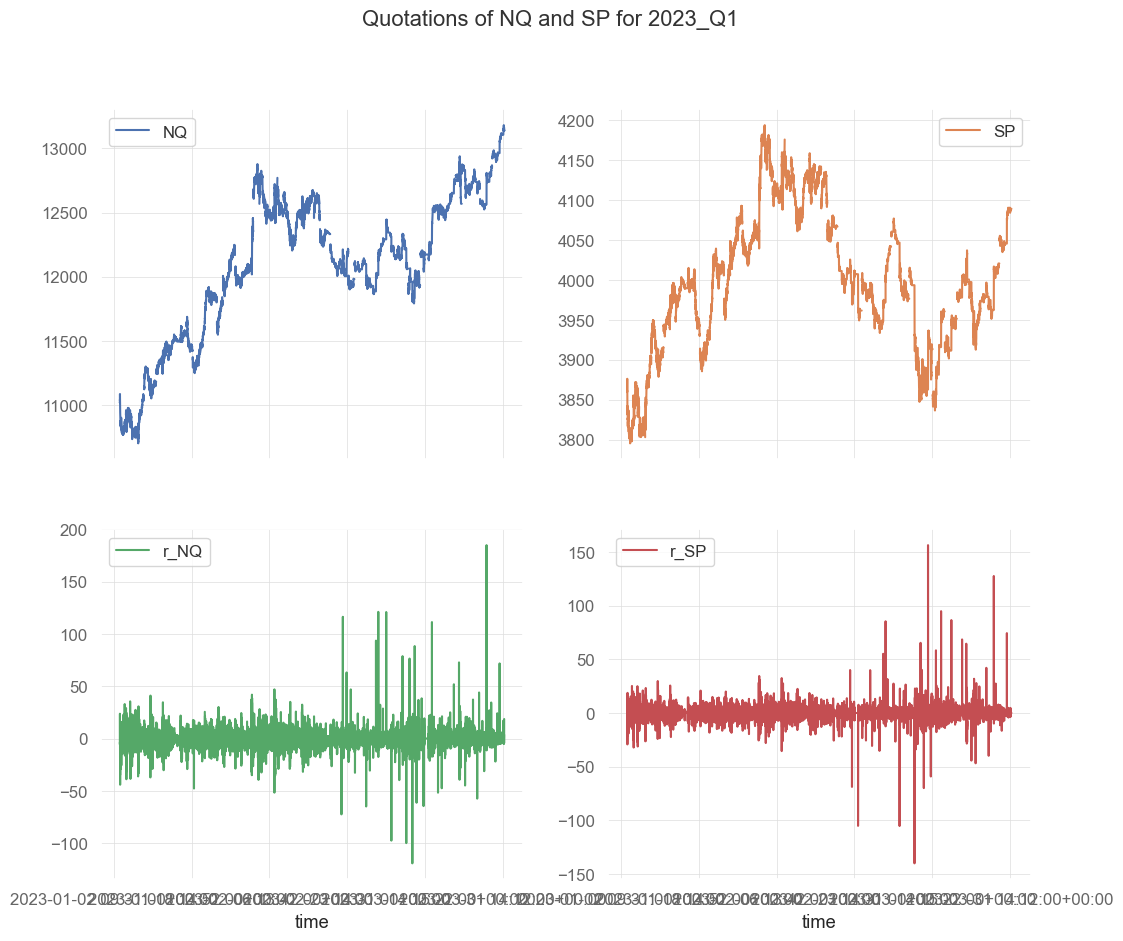

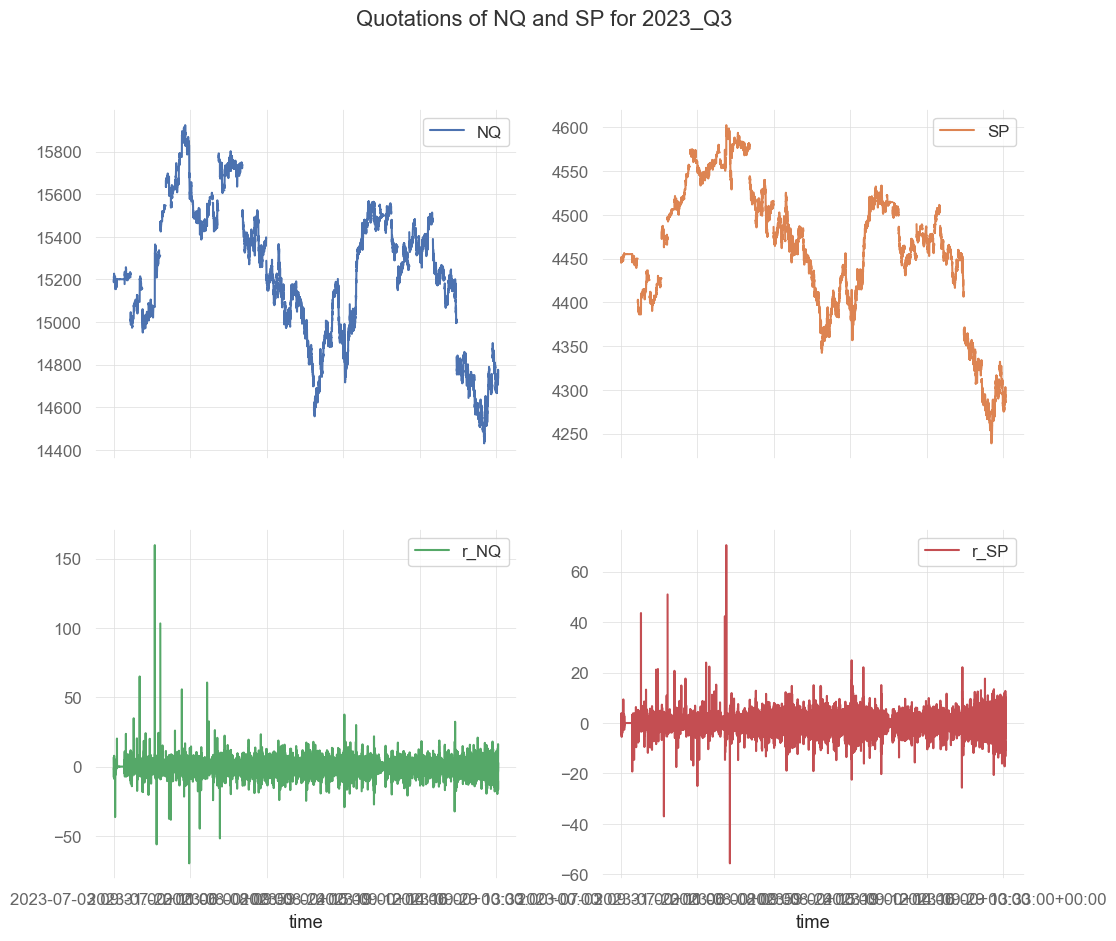

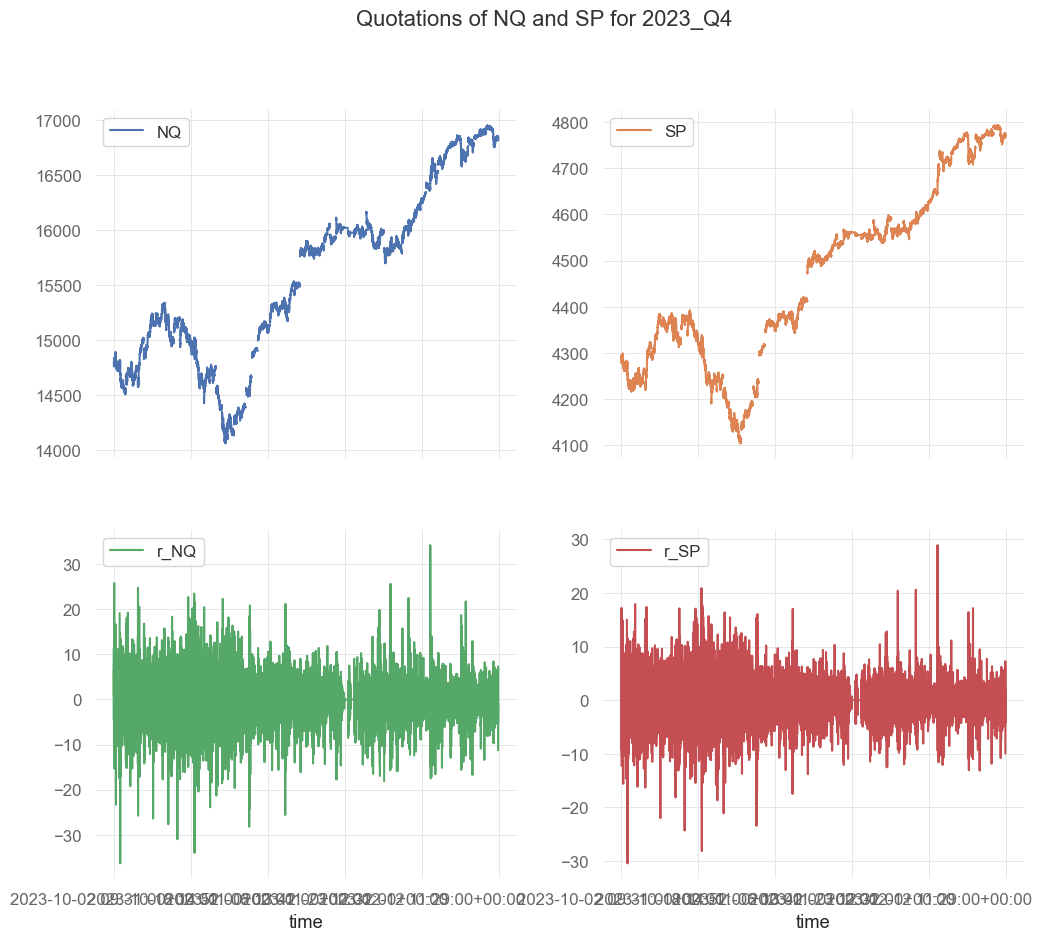

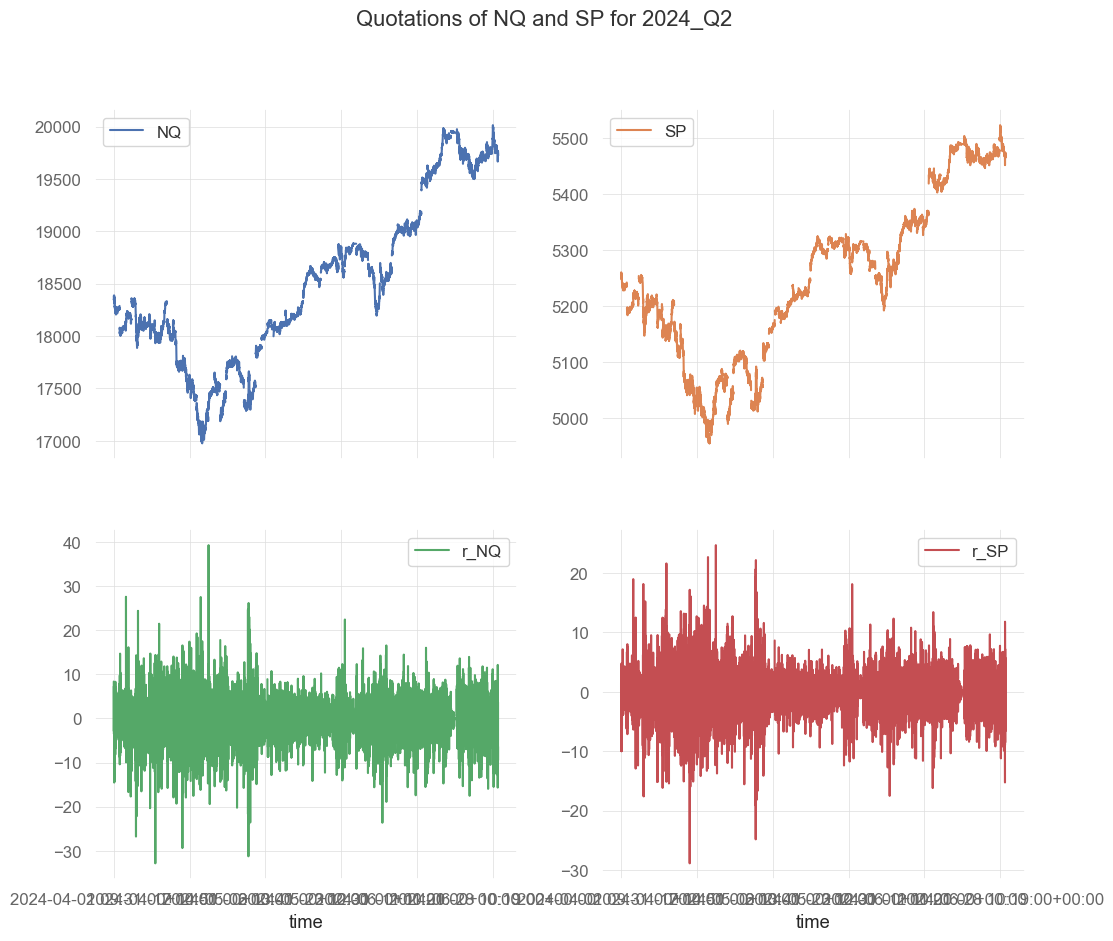

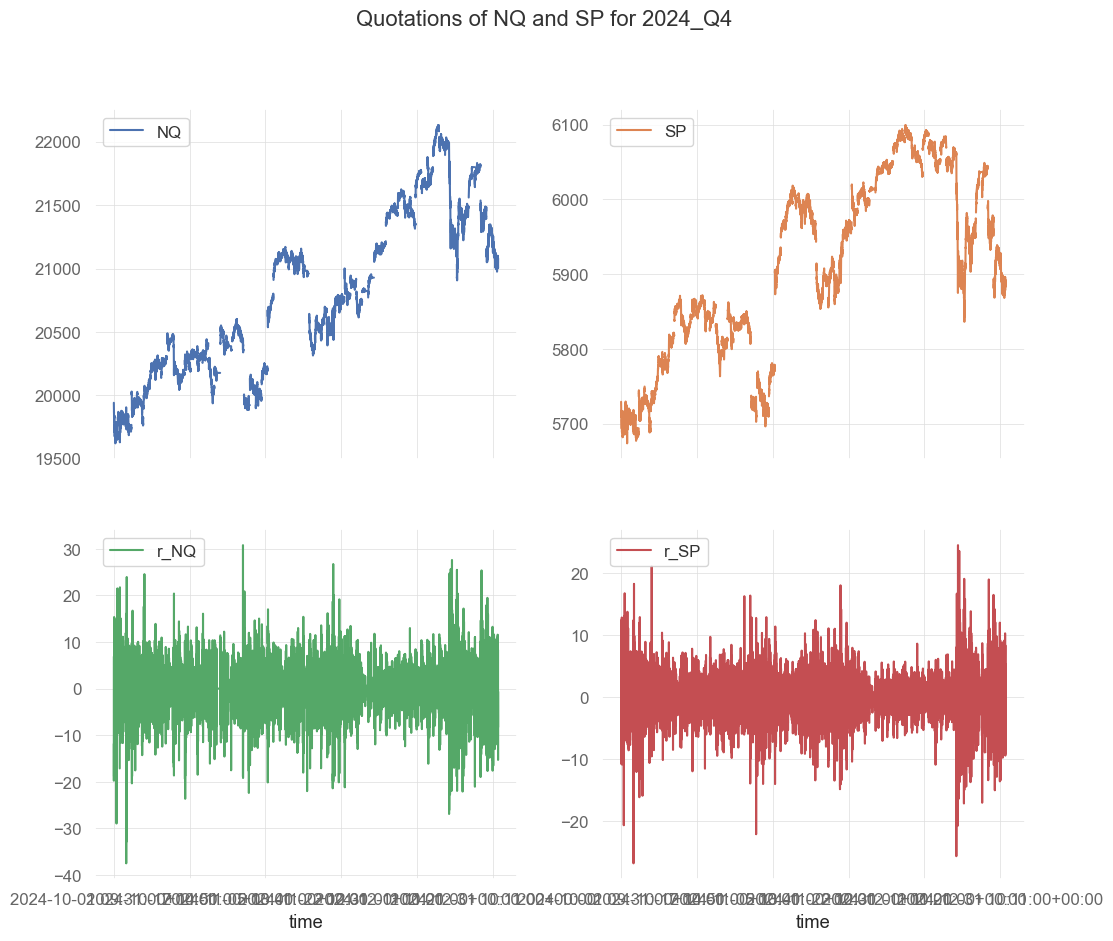

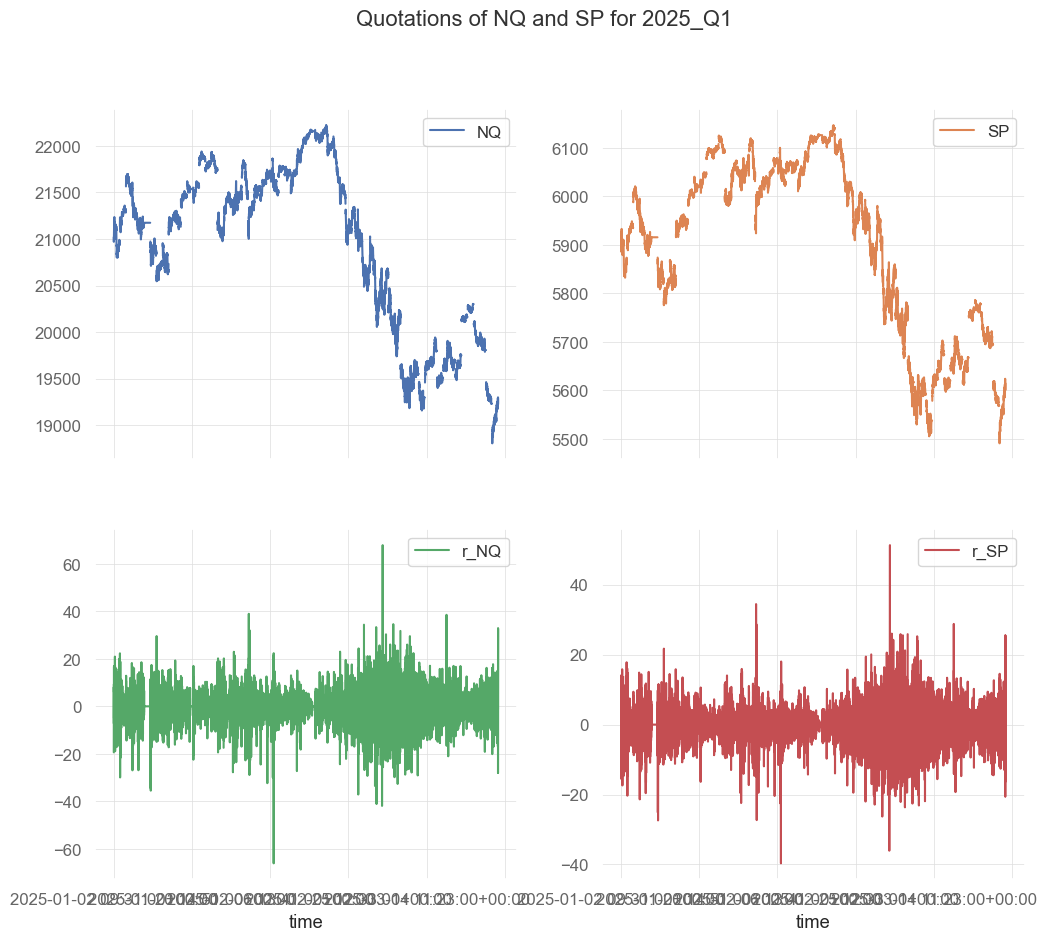

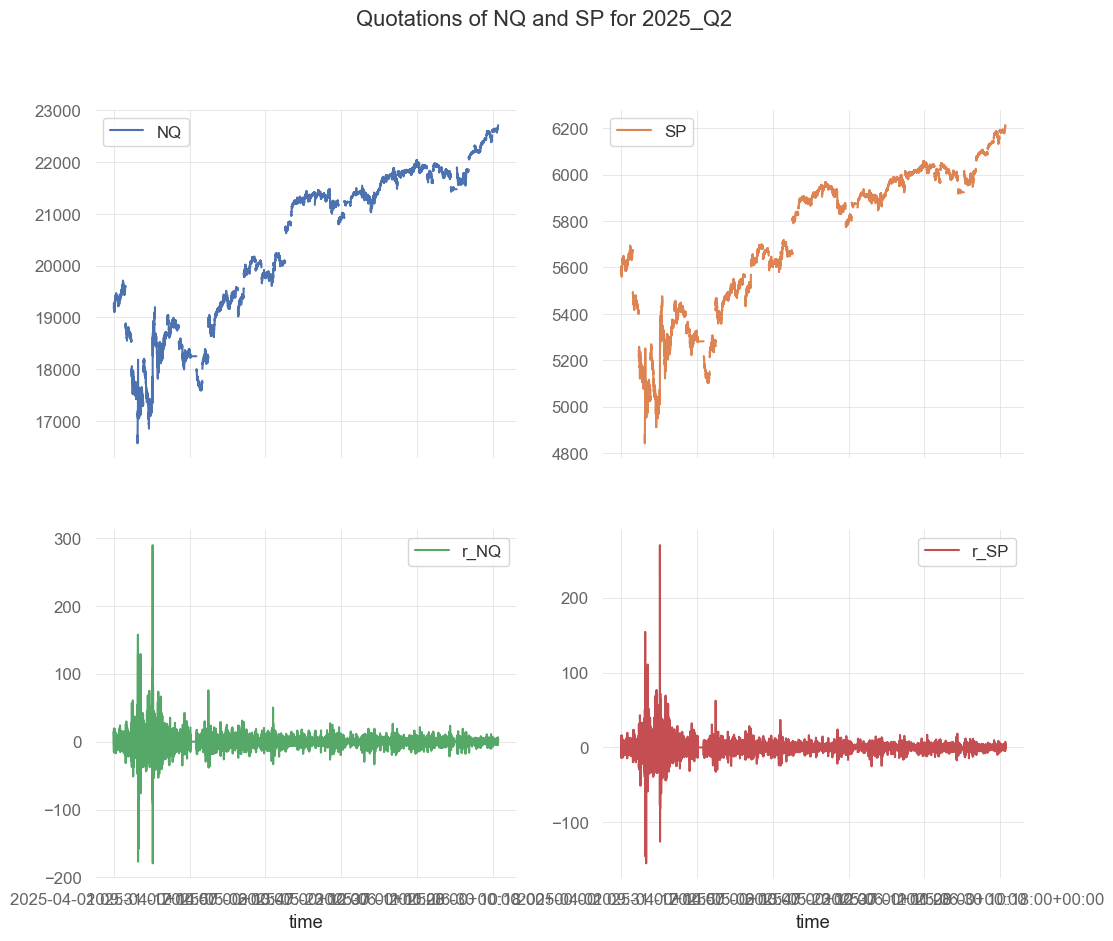

In [3]:
for quarter in quarters:

    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')
    data1['datetime'] = pd.to_datetime(data1['datetime'])
    data1.set_index('datetime', inplace = True)
    #data1.loc[data1.between_time("9:31", "9:40").index] = np.nan
    #data1.loc[data1.between_time("15:51", "16:00").index] = np.nan

    data_r = np.log(data1 / data1.shift(1)) * 10000

    # changing the column names to make them appropriate
    # (replace close_ with r_ )

    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_NQ_SP = pd.concat(
        [data1[['NQ', 'SP']],
        data_r[['r_NQ', 'r_SP']]],
        axis=1
    )

    data_NQ_SP.loc[data_NQ_SP.between_time("9:31", "9:35").index] = np.nan
    data_NQ_SP.loc[data_NQ_SP.between_time("15:56", "16:00").index] = np.nan

    # and make the plots again

    # Let's convert the datetime index to a text index and pass it as the x-axis
    data_NQ_SP_plot = data_NQ_SP.copy()
    data_NQ_SP_plot['time'] = data_NQ_SP_plot.index.astype(str)

    # We reset the index to make 'time' a column
    data_NQ_SP_plot = data_NQ_SP_plot.reset_index(drop = True)

    # Let's set time as the X-axis and draw the graphs
    data_NQ_SP_plot.plot(
        x = 'time',
        subplots = True,
        layout = (2, 2),
        title = "Quotations of NQ and SP for" + f" {quarter}",
        figsize = (12, 10)
    )
    plt.show()
    
    

In [4]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller

# Check cointegration between NQ and SP using the Engle-Granger test

# Get the price series (not returns) for cointegration test
nq_prices = data_NQ_SP['NQ'].dropna()
sp_prices = data_NQ_SP['SP'].dropna()
# Check stationarity of both price series using Augmented Dickey-Fuller test
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"\nStationarity Test for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"P-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    
    if result[1] <= 0.05:
        print(f"Result: {name} is stationary (p <= 0.05)")
    else:
        print(f"Result: {name} is NOT stationary (p > 0.05)")

# Test stationarity of both series
check_stationarity(nq_prices, "NQ Prices")
check_stationarity(sp_prices, "SP Prices")
# Perform Engle-Granger cointegration test
coint_stat, p_value, critical_values = coint(nq_prices, sp_prices)

print(f"Cointegration Test Results for NQ and SP:")
print(f"Test Statistic: {coint_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Critical Values:")
print(f"  1%: {critical_values[0]:.4f}")
print(f"  5%: {critical_values[1]:.4f}")
print(f"  10%: {critical_values[2]:.4f}")

# Interpretation
if p_value < 0.05:
    print("\nResult: The series are cointegrated (p < 0.05)")
else:
    print("\nResult: The series are NOT cointegrated (p >= 0.05)")


Stationarity Test for NQ Prices:
ADF Statistic: -0.5942
P-value: 0.8723
Critical Values:
  1%: -3.4306
  5%: -2.8617
  10%: -2.5668
Result: NQ Prices is NOT stationary (p > 0.05)

Stationarity Test for SP Prices:
ADF Statistic: -0.7386
P-value: 0.8365
Critical Values:
  1%: -3.4306
  5%: -2.8617
  10%: -2.5668
Result: SP Prices is NOT stationary (p > 0.05)
Cointegration Test Results for NQ and SP:
Test Statistic: -4.1085
P-value: 0.0050
Critical Values:
  1%: -3.8969
  5%: -3.3364
  10%: -3.0446

Result: The series are cointegrated (p < 0.05)


In [13]:
correlation_p = data_NQ_SP['NQ'].corr(data_NQ_SP['SP'])
correlation_r = data_NQ_SP['r_NQ'].corr(data_NQ_SP['r_SP'])

print("KO and PEP closing price correlation:")
print(correlation_p)

print("KO and PEP returns correlation:")
print(correlation_r)


KO and PEP closing price correlation:
0.9955915894498178
KO and PEP returns correlation:
0.9463708136052346


In [14]:
correlation_p_daily = data_NQ_SP.resample("D").apply(lambda x: x['NQ'].corr(x['SP']))
correlation_r_daily = data_NQ_SP.resample("D").apply(lambda x: x['r_NQ'].corr(x['r_SP']))

# and drop NaN values
correlation_p_daily = correlation_p_daily.dropna()
correlation_r_daily = correlation_r_daily.dropna()

/Users/joannamisiak/Desktop/STUDIA/HFD/HFD_Trading_Competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/joannamisiak/Desktop/STUDIA/HFD/HFD_Trading_Competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/joannamisiak/Desktop/STUDIA/HFD/HFD_Trading_Competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


<Axes: title={'center': 'Daily correlation between KO and PEP prices'}, xlabel='datetime'>

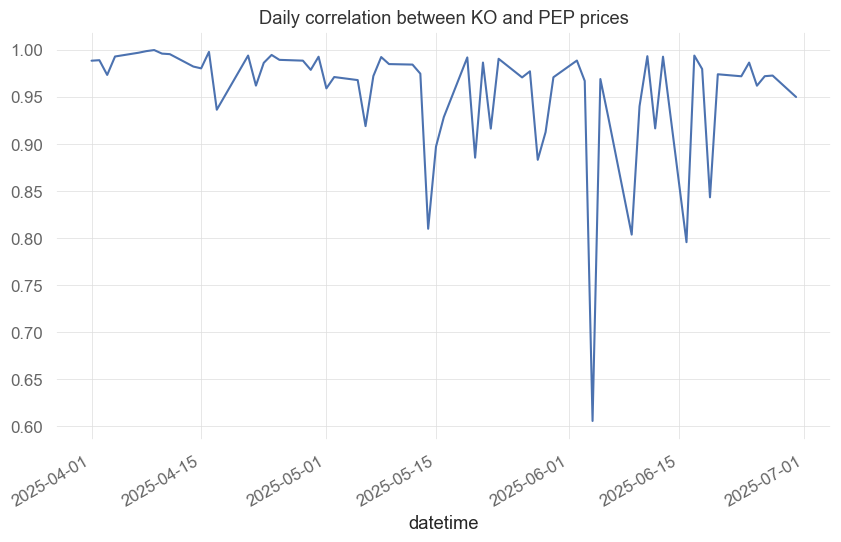

In [15]:
correlation_p_daily.plot(title="Daily correlation between KO and PEP prices")

In [16]:
# lets check how often daily correlation between prices 
# is above 0.6, 0.7, 0.8 and 0.9

print("Share of days with correlation above 0.6:", 
      (correlation_p_daily > 0.6).sum() / len(correlation_p_daily))

print("Share of days with correlation above 0.7:", 
      (correlation_p_daily > 0.7).sum() / len(correlation_p_daily))

print("Share of days with correlation above 0.8:", 
      (correlation_p_daily > 0.8).sum() / len(correlation_p_daily))

print("Share of days with correlation above 0.9:", 
      (correlation_p_daily > 0.9).sum() / len(correlation_p_daily))

Share of days with correlation above 0.6: 1.0
Share of days with correlation above 0.7: 0.984375
Share of days with correlation above 0.8: 0.96875
Share of days with correlation above 0.9: 0.875


<Axes: title={'center': 'Daily correlation between KO and PEP returns'}, xlabel='datetime'>

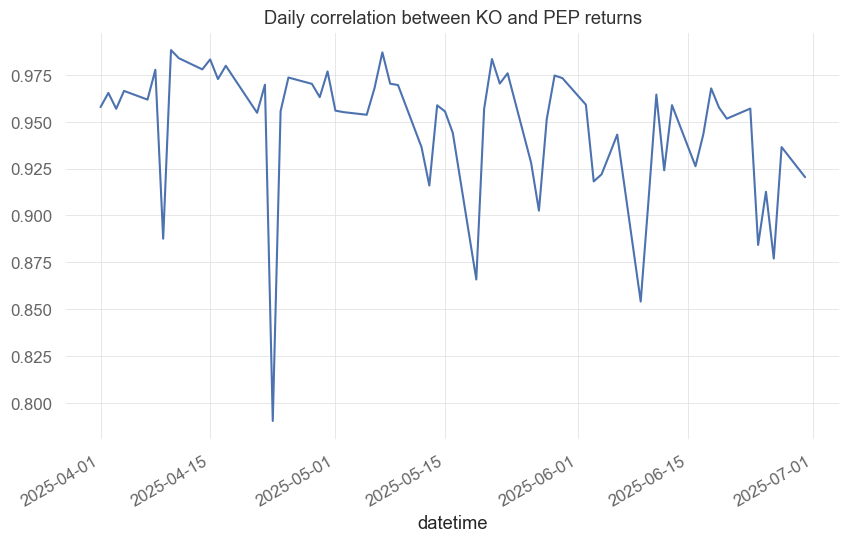

In [17]:
# the same for correlation between returns

correlation_r_daily.plot(title="Daily correlation between KO and PEP returns")

In [27]:
data_NQ_SP_nonans

,NQ,SP,r_NQ,r_SP
datetime,,,,
2025-04-01 09:36:00+00:00,19166.731,5587.116,-14.614658,-5.146233
2025-04-01 09:37:00+00:00,19195.352,5587.128,14.921507,0.021478
2025-04-01 09:38:00+00:00,19168.085,5583.628,-14.215100,-6.266362
2025-04-01 09:39:00+00:00,19180.352,5587.366,6.397653,6.692332
2025-04-01 09:40:00+00:00,19208.896,5591.866,14.870833,8.050643
...,...,...,...,...
2025-06-30 15:51:00+00:00,22691.186,6210.103,5.431336,7.464820
2025-06-30 15:52:00+00:00,22695.265,6210.909,1.797453,1.297801
2025-06-30 15:53:00+00:00,22694.064,6210.861,-0.529199,-0.077284


In [ ]:
# lets use PP and KPSS tests for cointegration
# based on the functions from lab03
# extended to control for empty dataframes

from arch.unitroot import PhillipsPerron, KPSS
import statsmodels.api as sm
data_NQ_SP_nonans = data_NQ_SP.dropna()

# the function to get residuals from OLS regression
def _eg_residuals(df: pd.DataFrame, col1: str, col2: str):
    X = sm.add_constant(df[col1].values, has_constant="add")
    y = df[col2].values
    model = sm.OLS(y, X).fit()
    return model.resid

# the function for PP p-value
def eg_pp_pvalue(df: pd.DataFrame, col1: str, col2: str, 
                 trend: str = "c") -> float:
    # If the group is empty return NaN
    if df.empty:
        return np.nan

    resid = _eg_residuals(df, col1, col2)
    return float(PhillipsPerron(resid, trend=trend).pvalue)

# the function for KPSS p-value
def eg_kpss_pvalue(df: pd.DataFrame, col1: str, col2: str, 
                   trend: str = "c") -> float:
    # If the group is empty return NaN
    if df.empty:
        return np.nan
    resid = _eg_residuals(df, col1, col2)
    return float(KPSS(resid, trend=trend).pvalue)

# check cointegration for the whole sample

print("p-value of PP test:", eg_pp_pvalue(data_NQ_SP_nonans, "NQ", "SP"))
print("p-value of KPSS test:", eg_kpss_pvalue(data_NQ_SP_nonans, "NQ", "SP"))


p-value of PP test: 0.0002954912875695701
p-value of KPSS test: 0.0001


/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_80751/2462126393.py:33: DeprecationWarning: Lag selection has changed to use a data-dependent method. To use the old method that only depends on time, set lags=-1
  return float(KPSS(resid, trend=trend).pvalue)


In [28]:
# how about daily cointegration tests?

daily_PP_tests = data_NQ_SP_nonans.resample("D").apply(
    lambda g: eg_pp_pvalue(g, "NQ", "SP")
)

daily_KPSS_tests = data_NQ_SP_nonans.resample("D").apply(
    lambda g: eg_kpss_pvalue(g, "NQ", "SP")
)

# remove NaN values
daily_PP_tests = daily_PP_tests.dropna()
daily_KPSS_tests = daily_KPSS_tests.dropna()

ValueError: Shape of passed values is (379, 0), indices imply (379, 1)

In [ ]:
# lets plot p-values of both tests
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(daily_PP_tests, label="PP test p-value")
plt.axhline(y=0.05, color='r', linestyle='--', label='5% significance level')
plt.title("Daily p-values of Phillips-Perron test for cointegration between KO and PEP prices")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(daily_KPSS_tests, label="KPSS test p-value")
plt.axhline(y=0.05, color='r', linestyle='--', label='5% significance level')
plt.title("Daily p-values of KPSS test for cointegration between KO and PEP prices")
plt.legend()
plt.tight_layout()
plt.show()

Chyba mozna potraktowac pierwszą grupę assetów jako spread. 

### Asset Class 2: currencies and metals

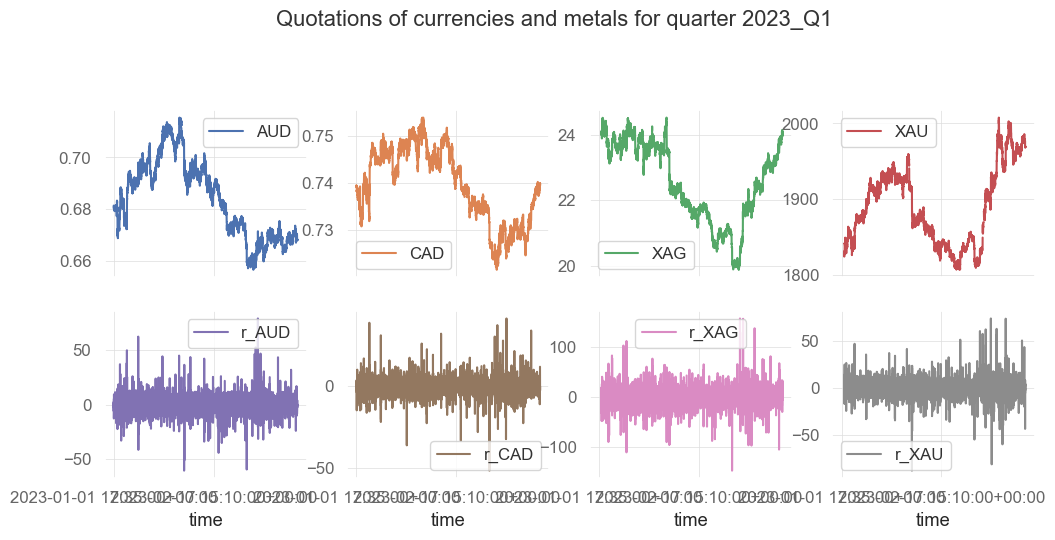

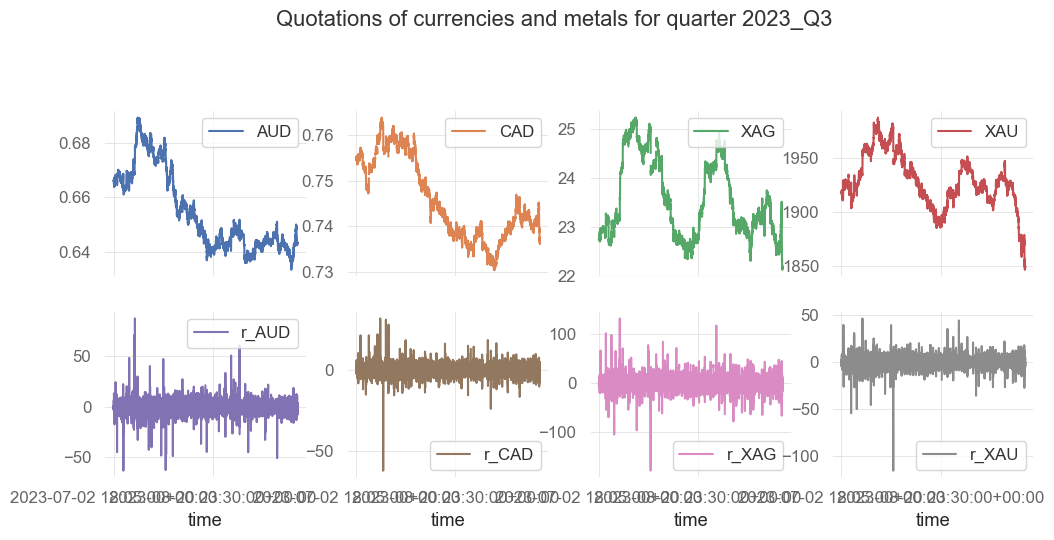

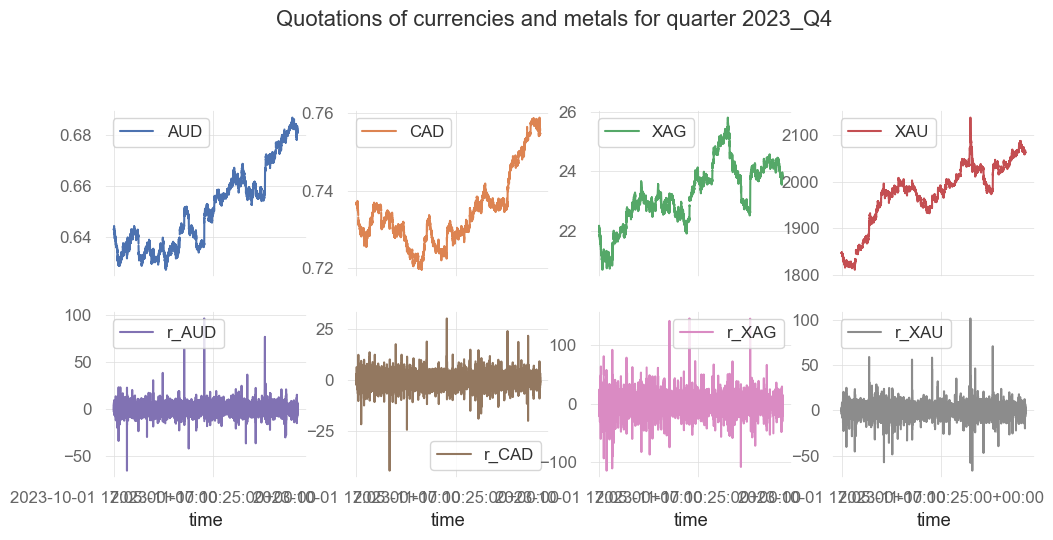

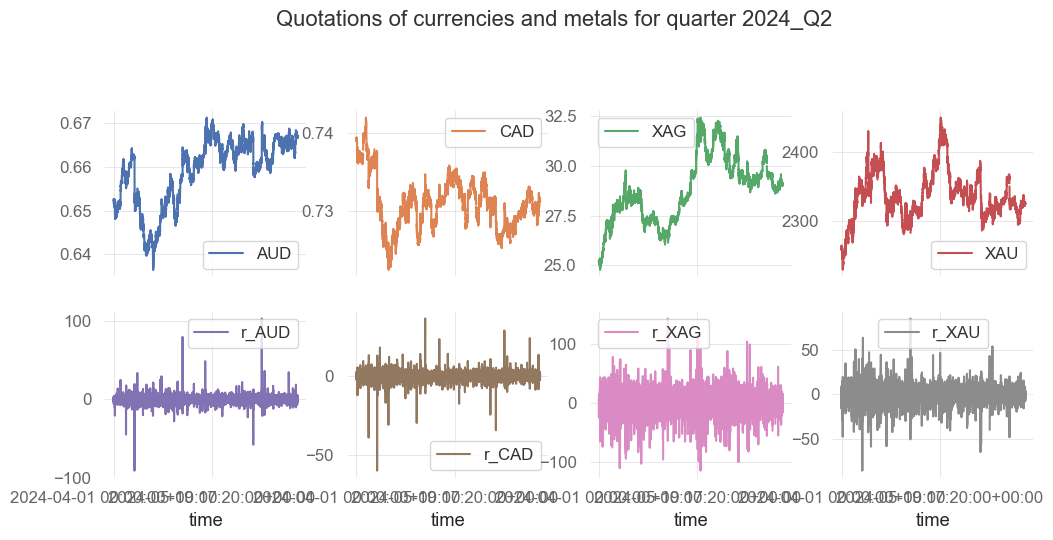

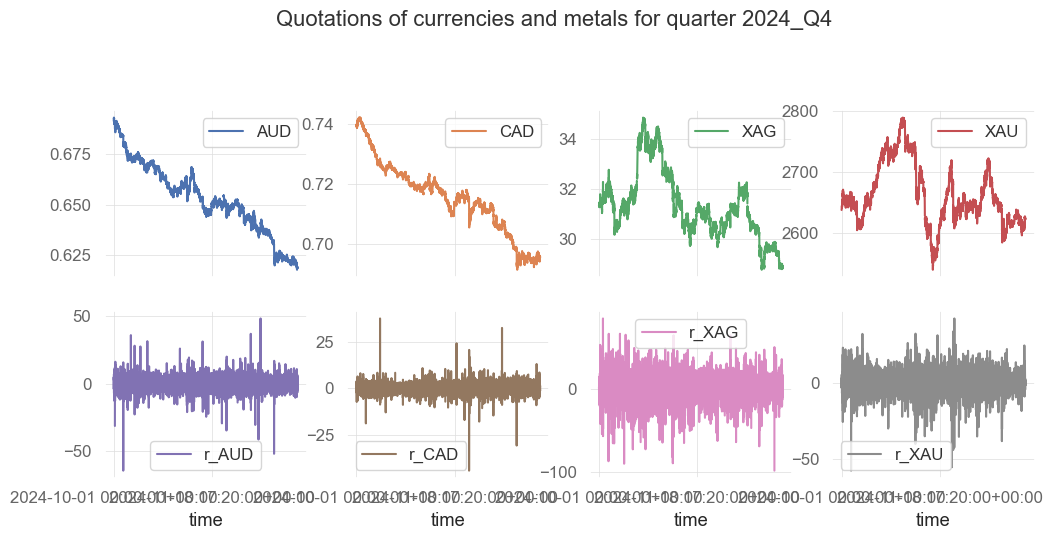

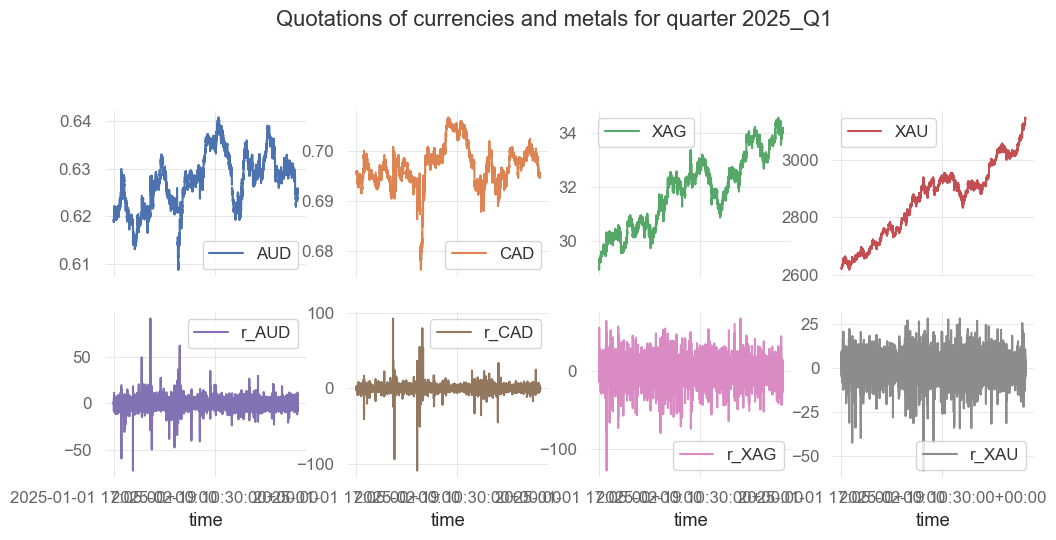

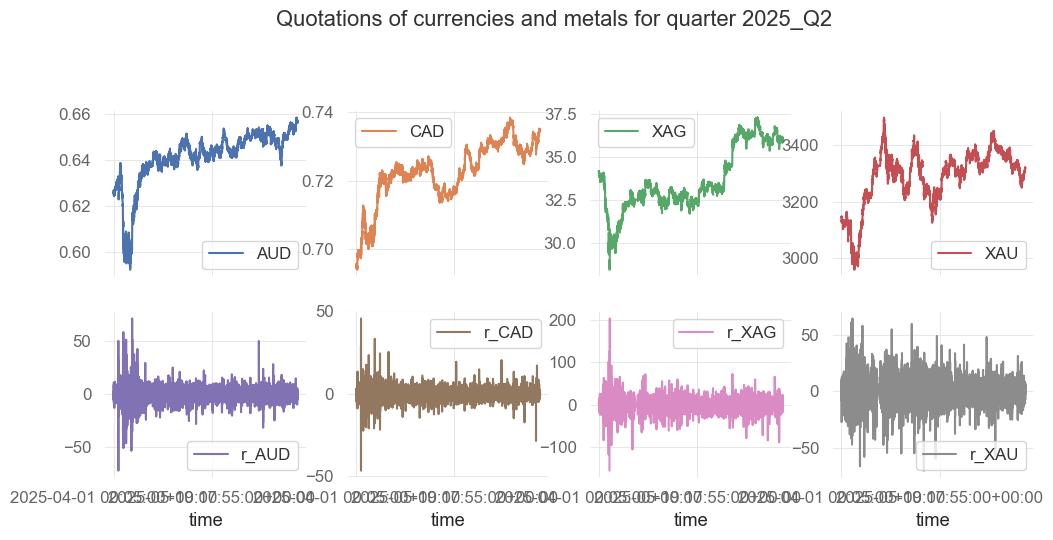

In [5]:
for quarter in quarters:

    data2 = pd.read_parquet(f'data/data2_{quarter}.parquet')
    data2['datetime'] = pd.to_datetime(data2['datetime'])
    data2.set_index('datetime', inplace = True)
    #data1.loc[data1.between_time("9:31", "9:40").index] = np.nan
    #data1.loc[data1.between_time("15:51", "16:00").index] = np.nan

    data_r = np.log(data2 / data2.shift(1)) * 10000

    # changing the column names to make them appropriate
    # (replace close_ with r_ )

    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_currencies = pd.concat(
        [data2[['AUD', 'CAD', 'XAG', 'XAU']],
        data_r[['r_AUD', 'r_CAD', 'r_XAG', 'r_XAU']]],
        axis=1
    )

    data_currencies.loc[data_currencies.between_time("9:31", "9:35").index] = np.nan
    data_currencies.loc[data_currencies.between_time("15:56", "16:00").index] = np.nan

    # and make the plots again

    # Let's convert the datetime index to a text index and pass it as the x-axis
    data_currencies_plot = data_currencies.copy()
    data_currencies_plot['time'] = data_currencies_plot.index.astype(str)

    # We reset the index to make 'time' a column
    data_currencies_plot = data_currencies_plot.reset_index(drop = True)

    # Let's set time as the X-axis and draw the graphs
    data_currencies_plot.plot(
        x = 'time',
        subplots = True,
        layout = (4,4),
        title = "Quotations of currencies and metals for quarter" + f" {quarter}",
        figsize = (12, 10)
    )
    plt.show()
    
    

In [ ]:
# Get the price series (not returns) for cointegration test
aud_prices = data_currencies['AUD'].dropna()
cad_prices = data_currencies['CAD'].dropna()
# XAG and XAU can also be tested similarly
xag_prices = data_currencies['XAG'].dropna()
xau_prices = data_currencies['XAU'].dropna()

# Check stationarity of both price series using Augmented Dickey-Fuller test
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"\nStationarity Test for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"P-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    
    if result[1] <= 0.05:
        print(f"Result: {name} is stationary (p <= 0.05)")
    else:
        print(f"Result: {name} is NOT stationary (p > 0.05)")

# Test stationarity of both series
check_stationarity(aud_prices, "AUD Prices")
check_stationarity(cad_prices, "CAD Prices")
check_stationarity(xag_prices, "XAG Prices")
check_stationarity(xau_prices, "XAU Prices")

# Perform Engle-Granger cointegration test
coint_stat, p_value, critical_values = coint(aud_prices, xau_prices)

print(f"\nCointegration Test Results for AUD and XAU:")
print(f"Test Statistic: {coint_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Critical Values:")
print(f"  1%: {critical_values[0]:.4f}")
print(f"  5%: {critical_values[1]:.4f}")
print(f"  10%: {critical_values[2]:.4f}")

# Interpretation
if p_value < 0.05:
    print("\nResult: The series are cointegrated (p < 0.05)")
else:
    print("\nResult: The series are NOT cointegrated (p >= 0.05)")

coint_stat, p_value, critical_values = coint(cad_prices, xag_prices)

print(f"\nCointegration Test Results for XAG and CAD:")
print(f"Test Statistic: {coint_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Critical Values:")
print(f"  1%: {critical_values[0]:.4f}")
print(f"  5%: {critical_values[1]:.4f}")
print(f"  10%: {critical_values[2]:.4f}")

# Interpretation
if p_value < 0.05:
    print("\nResult: The series are cointegrated (p < 0.05)")
else:
    print("\nResult: The series are NOT cointegrated (p >= 0.05)")



Stationarity Test for AUD Prices:
ADF Statistic: -1.7278
P-value: 0.4169
Critical Values:
  1%: -3.4307
  5%: -2.8617
  10%: -2.5669
Result: AUD Prices is NOT stationary (p > 0.05)

Stationarity Test for CAD Prices:
ADF Statistic: -2.8564
P-value: 0.0507
Critical Values:
  1%: -3.4307
  5%: -2.8617
  10%: -2.5669
Result: CAD Prices is NOT stationary (p > 0.05)

Stationarity Test for XAG Prices:
ADF Statistic: -0.8498
P-value: 0.8040
Critical Values:
  1%: -3.4307
  5%: -2.8617
  10%: -2.5669
Result: XAG Prices is NOT stationary (p > 0.05)

Stationarity Test for XAU Prices:
ADF Statistic: -2.2338
P-value: 0.1942
Critical Values:
  1%: -3.4307
  5%: -2.8617
  10%: -2.5669
Result: XAU Prices is NOT stationary (p > 0.05)

Cointegration Test Results for AUD and XAU:
Test Statistic: -3.3519
P-value: 0.0480
Critical Values:
  1%: -3.8971
  5%: -3.3365
  10%: -3.0447

Result: The series are cointegrated (p < 0.05)

Cointegration Test Results for XAU and CAD:
Test Statistic: -5.0265
P-value: 0

AUD i XAU są skointegrowane - można potraktować je jako spread. CAD i XAG też są skointegrowane - można potraktować je jako spread. 